In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2
import os
import seaborn as sns
from tensorflow.keras.applications.resnet50 import ResNet50
import warnings
from sklearn.exceptions import ConvergenceWarning
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=ConvergenceWarning)


In [2]:
#=================================INPUT========================================
path = 'dataset/train/'
# categories
categories = [ 'COVID', 'Normal', 'Viral Pneumonia']


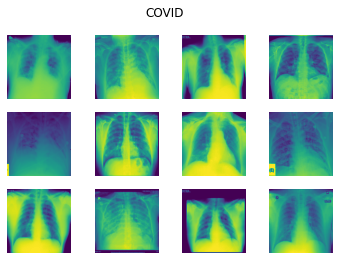

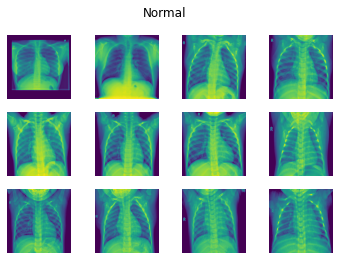

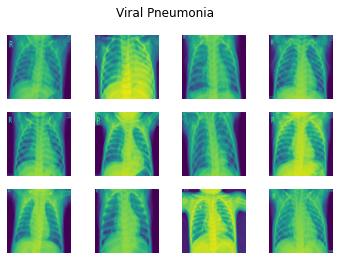

In [3]:
# let's display some of the pictures
for category in categories:
    fig, _ = plt.subplots(3,4)
    fig.suptitle(category)
    fig.patch.set_facecolor('xkcd:white')
    for k, v in enumerate(os.listdir(path+category)[:12]):
        img = plt.imread(path+category+'/'+v)
        plt.subplot(3, 4, k+1)
        plt.axis('off')
        plt.imshow(img)
    plt.show()


In [4]:
shape0 = []
shape1 = []

for category in categories:
    for files in os.listdir(path+category):
       # print(plt.imread(path+category+'/'+ files).shape[])
        shape0.append(plt.imread(path+category+'/'+ files).shape[0])
        shape1.append(plt.imread(path+category+'/'+ files).shape[1])
    print(category, ' => height min : ', min(shape0), 'width min : ', min(shape1))
    print(category, ' => height max : ', max(shape0), 'width max : ', max(shape1))
   
    shape0 = []
    shape1 = []
# Read input images and assign labels based on folder names
print(os.listdir("dataset/"))


COVID  => height min :  299 width min :  299
COVID  => height max :  299 width max :  299
Normal  => height min :  299 width min :  299
Normal  => height max :  299 width max :  299
Viral Pneumonia  => height min :  299 width min :  299
Viral Pneumonia  => height max :  299 width max :  299
['test', 'train']


PREPROCESSSING

COVID
Normal
Viral Pneumonia


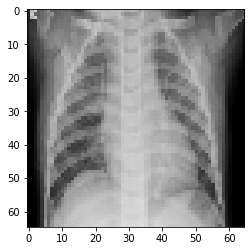

In [5]:
#==============================PRE-PROCESSING==================================
SIZE = 65  #Resize images

#Capture training data and labels into respective lists
train_images = []      
train_labels = [] 

for directory_path in glob.glob("dataset/train/*"):
    label = directory_path.split("\\")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
#        print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        plt.imshow(img)
        img = cv2.resize(img, (SIZE, SIZE))
        plt.imshow(img)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        train_labels.append(label)


In [8]:
#Convert lists to arrays        
train_images = np.array(train_images)
train_labels = np.array(train_labels)


In [9]:
# Capture test/validation data and labels into respective lists

test_images = []
test_labels = [] 
for directory_path in glob.glob("dataset/test/*"):
    fruit_label = directory_path.split("\\")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        test_images.append(img)
        test_labels.append(fruit_label)

 MODEL SELECTION

In [10]:
#===============================MODEL SELECTION================================
#Convert lists to arrays                
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [11]:
#Encode labels from text to integers.
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

#Split data into test and train datasets (already split but assigning to meaningful convention)
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

# Normalize pixel values to between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

#One hot encode y values for neural network. 
from tensorflow.keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)


In [13]:




#FEATURE EXTRCTION

In [14]:
#============================FEATURE EXTRACTION================================
#Load model wothout classifier/fully connected layers
ResNet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))

#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in ResNet50_model.layers:
	layer.trainable = False
    
ResNet50_model.summary()  #Trainable parameters will be 0


#Now, let us use features from convolutional network for SVM
feature_extractor=ResNet50_model.predict(x_train)

features = feature_extractor.reshape(feature_extractor.shape[0], -1)

X_for_SVM = features #This is our X input to SVM

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 65, 65, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 71, 71, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 33, 33, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 33, 33, 64)   256         ['conv1_conv[0][0]']             
                                                                                           

In [ ]:
print('SUPPORT VECTOR MACHINE')
from sklearn import svm
from sklearn.model_selection import cross_val_score,KFold
#liblinear svm
#SVM_model=svm.LinearSVC()
#cubic svm
SVM_model = svm.SVC(C=1.0, kernel='poly', degree=3, gamma=2,max_iter = 1e5)

#10 fold crossvalidation
kf=KFold(n_splits=10)

score=cross_val_score(SVM_model,X_for_SVM, y_train,cv=kf)

# Train the model on training data
SVM_model.fit(X_for_SVM, y_train) #For sklearn no one hot encoding

#Send test data through same feature extractor process
X_test_feature = ResNet50_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
                                                           
#Now predict using the trained SVM model. 
prediction_SVM = SVM_model.predict(X_test_features)
#Inverse le transform to get original label back. 
prediction_SVM = le.inverse_transform(prediction_SVM)


SUPPORT VECTOR MACHINE


SVM Accuracy =  100.0 %
Cross Validation Scores are [0.86       0.88       0.91333333 0.88666667 0.86666667 0.85333333
 0.88666667 0.88       0.80666667 0.89333333]
Average Cross Validation score :0.8726666666666667
                 precision    recall  f1-score   support

          COVID       1.00      1.00      1.00       200
         Normal       1.00      1.00      1.00       200
Viral Pneumonia       1.00      1.00      1.00       200

       accuracy                           1.00       600
      macro avg       1.00      1.00      1.00       600
   weighted avg       1.00      1.00      1.00       600

[[200   0   0]
 [  0 200   0]
 [  0   0 200]]


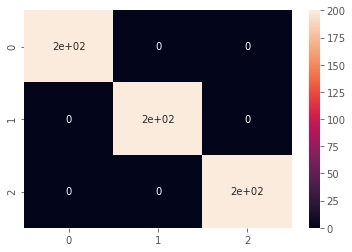

In [25]:
#Print overall accuracy
from sklearn import metrics
print ("SVM Accuracy = ", (metrics.accuracy_score(test_labels, prediction_SVM))*100,'%')
print("Cross Validation Scores are {}".format(score))
print("Average Cross Validation score :{}".format(score.mean()))
#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix, classification_report

cr=classification_report(test_labels, prediction_SVM)
print(cr)
cm = confusion_matrix(test_labels, prediction_SVM)
plt.style.use("ggplot")
print(cm)
sns.heatmap(cm, annot=True)
plt.show()

0
The prediction for this image is:  ['COVID']


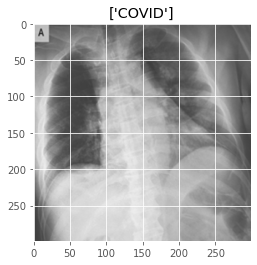

In [18]:
#===================================PREDICTION=================================
#Check results on a few select images
from tkinter import filedialog
test_data=[]
Image = filedialog.askopenfilename()
head_tail = os.path.split(Image)
fileNo=head_tail[1].split('.')
test_image_o = cv2.imread(head_tail[0]+'/'+fileNo[0]+'.png')
test_image = cv2.resize(test_image_o, (65, 65))
test_data.append(test_image)
# scale the raw pixel intensities to the range [0, 1]
test_data = np.array(test_image, dtype="float") / 255.0
input_img = np.expand_dims(test_data, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_feature=ResNet50_model.predict(input_img)
input_img_features=input_img_feature.reshape(input_img_feature.shape[0], -1)
prediction_SVM = SVM_model.predict(input_img_features)[0] 
print(prediction_SVM)
prediction_SVM = le.inverse_transform([prediction_SVM])  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction_SVM)

#Imersing into the plot
fig = plt.figure()
fig.patch.set_facecolor('xkcd:white')
plt.title(prediction_SVM)
plt.imshow(test_image_o)
plt.show()